### Defining Experiment

In [2]:
experiment = {
    
    'experiment_name' : 'AST',
    'collection' : '',
    'taxonomy_type' : '',
    'papers_type' : '_ENHANCED'
}
keywords = (experiment['collection'] == 'keywords')
shortcut = {'_ENHANCED':'enh', '':'std'}

In [3]:
from libs import *
np.set_printoptions(suppress=True)


EXP_DIR = f"experiments/{experiment['experiment_name']}/{experiment['collection']}"
makedir(EXP_DIR)

### Loading Relevance Matrix

In [4]:
# rel_mat = load_obj(
#     f'input_data/relevance_matrices/{experiment["experiment_name"]}\
# /rel_mat_{experiment["experiment_name"]}\
# _{"keywords_" if keywords else ""}\
# {shortcut[experiment["papers_type"]]}_{shortcut[experiment["taxonomy_type"]]}.pkl'
# )

topics_unique = load_obj(name=
                    f'input_data/taxonomies/unique_topics{experiment["taxonomy_type"]}'
                           )

indices_unique = load_obj(name=
                          f"input_data/taxonomies/unique_indices{experiment['taxonomy_type']}")

papers_df = pd.read_csv(f'input_data/text_collections/papers_df{experiment["papers_type"]}.csv',
                            index_col=0)

if keywords:
    papers_df['keywords'] = papers_df['keywords'].apply(eval)
    texts = papers_df['keywords'].apply(lambda x: ' '.join(x)).str.lower().to_numpy()

### Building Similarity Matrix

In [5]:
def diag_mult(v, M):
    result = M.copy()
    for i in range(M.shape[0]):
        result[i] = v[i]*result[i]    
    return result

In [6]:
rel_mat = load_obj(name=f'input_data/relevance_matrices/{experiment["experiment_name"]}/'+
f'rel_mat_{experiment["experiment_name"]}_{"keywords_" if keywords else ""}' + 
f'{shortcut[experiment["papers_type"]]}_{shortcut[experiment["taxonomy_type"]]}.pkl'
)
rel_mat[rel_mat<0.3] = .0
sim_mat = rel_mat.T@rel_mat



In [155]:
import custom_algorithms as custom
reload(custom)
import FADDIS
reload(FADDIS)

LapIn = custom.LapInTransformer()

LapIn.fit(sim_mat)

L_inv = LapIn.L_inv


clf1 = custom.FSC(mat_diff=0.0036, derivative_scale=0.005)
clf2 = custom.LaplacianFCM(n_clusters=10)
clf3 = FADDIS.FADDIS()

clf1.fit(sim_mat)
clf2.fit(sim_mat)
clf3.fit(L_inv)

Cluster contribution is too small


In [156]:
import utils
reload(utils)

cl1 = utils.Clusters(clf1.mm, topics=topics_unique, indices=indices_unique)
cl2 = utils.Clusters(clf2.mm, topics=topics_unique, indices=indices_unique)
cl3 = utils.Clusters(clf3.mm, topics=topics_unique, indices=indices_unique)



(cl1.mm).shape



(302, 11)

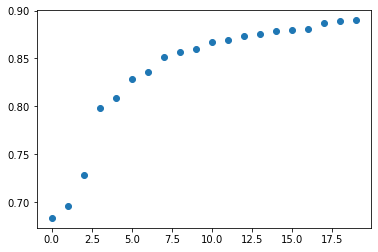

In [177]:
z = clf1.eigenvalues[:20]
plt.scatter(np.arange(len(z)), 
                      z)

In [185]:
cl1.show(10)

2.1.3.4   :: Expectation maximization :: 0.18
3.1.3.2.1 :: Query optimization       :: 0.18
3.4.3.1   :: Personalization          :: 0.15
4.1.3.1   :: Scientific visualization :: 0.11
3.4.5.9   :: Summarization            :: 0.11


### Clustering 

In [5]:
from sklearn.manifold import spectral_embedding
from sklearn.cluster import KMeans
from fcmeans import FCM
from LaplacianFCM import LaplacianFCM
from sklearn.decomposition import PCA
import utils

clf = LaplacianFCM(n_clusters=12, embedding_dim=12, random_state=1)

clf.fit(sim_mat)

In [6]:
import utils 
reload(utils)
from utils import Clusters

cl_fcm = Clusters(clf.fcm.u.copy(), topics_unique, clf.embedding, random_state=1)
cl_km = Clusters(clf.kmeans.u.copy(), topics_unique, clf.embedding, random_state=1)

### Lifting